# Exploratory Data Analysis

In this notebook you will explore the citation dataset. You should already have installed py2neo, pandas, and matplotlib when setting up our environment, so you will now import them (remember to unset Reset all runtimes before running):

In [1]:
from py2neo import Graph
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Next, create a connection to your Neo4j Sandbox, just as you did previously when you set up your environment. 

<div align="left">
    <img src="https://github.com/neo4j-contrib/training-v2/blob/master/Courses/DataScience/notebooks/images/sandbox-citations.png?raw=1" alt="Citation Sandbox"/>
</div>

Update the cell below to use the IP Address, Bolt Port, and Password, as you did previously.

In [2]:
# Change the line of code below to use the IP Address, Bolt Port, and Password of your Sandbox.
# graph = Graph("bolt://<IP Address>:<Bolt Port>", auth=("neo4j", "<Password>")) 
 
#graph = Graph("bolt://52.3.242.176:33698", auth=("neo4j", "equivalent-listing-parts"))
graph = Graph("bolt:localhost:7687", auth=("neo4j", "graphdb"))

## What's in our database?

Run the following query to check how many nodes our database contains:

In [3]:
graph.run("CALL db.schema()").data()

[{'nodes': [(_-6:Venue {constraints: ['CONSTRAINT ON ( venue:Venue ) ASSERT venue.name IS UNIQUE'], indexes: [], name: 'Venue'}),
   (_-4:Article {constraints: ['CONSTRAINT ON ( article:Article ) ASSERT article.index IS UNIQUE'], indexes: [], name: 'Article'}),
   (_-5:Author {constraints: ['CONSTRAINT ON ( author:Author ) ASSERT author.name IS UNIQUE'], indexes: [], name: 'Author'})],
  'relationships': [(Article)-[:VENUE {}]->(Venue),
   (Article)-[:AUTHOR {}]->(Author),
   (Article)-[:CITED {}]->(Article)]}]

If we run that query (CALL db.schema()) in  Neo4j Browser, you see the following visualisation:

<img src="https://github.com/neo4j-contrib/training-v2/blob/master/Courses/DataScience/notebooks/images/data-science-training.png?raw=1" alt="Graph Data Model"/>


Let's drill down a bit. How many nodes do we have for each of these labels? Run this code:

In [4]:
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
2,Venue,4
0,Article,51956
1,Author,80299


You can visualize the counts using matplotlib> Run the following code:

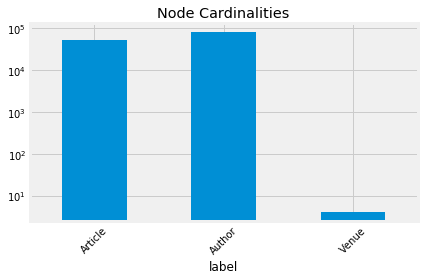

In [5]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

What types of relationships do we have in our graph? Run this code:

In [6]:
result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relType,count
2,CITED,28706
0,VENUE,51956
1,AUTHOR,140575


You can visualize the counts using matplotlib. Run  the following code:

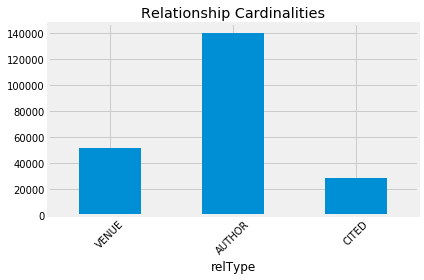

In [7]:
rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now let's explore the citation data. The following query finds 25 authors, articles, venues, and also shows the number of articles that article has cited, as well as the number of articles that it's been cited by.
Run this code:

In [8]:
exploratory_query = """
MATCH (author:Author)<-[:AUTHOR]-(article:Article)-[:VENUE]->(venue)
RETURN article.title AS article, author.name AS author, venue.name AS venue, 
       size((article)-[:CITED]->()) AS citationsGiven, size((article)<-[:CITED]-()) AS citationsReceived
ORDER BY rand()
LIMIT 25
"""

graph.run(exploratory_query).to_data_frame()

,article,author,venue,citationsGiven,citationsReceived
0,Efficient maximum flow algorithms,Robert Endre Tarjan,Communications of The ACM,0,0
1,"""Yes, it can be done""",Moshe Y. Vardi,Communications of The ACM,0,0
2,Crystal lattice automata,Robert E. Mercer,Lecture Notes in Computer Science,0,0
3,A randomly perturbed iterative proper orthogon...,Suman Chakravorty,advances in computing and communications,0,0
4,An Overview of Probabilistic Process Algebras ...,Natalia López,Lecture Notes in Computer Science,2,1
5,"A scheme for the introduction of 3rd party, ap...",Lazaros F. Merakos,Lecture Notes in Computer Science,0,0
6,Partial evaluation for the lambda calculus,Peter Sestoft,Lecture Notes in Computer Science,0,0
7,A Unified Approach to Related-Key Attacks,Orr Dunkelman,Lecture Notes in Computer Science,0,0
8,Ripple reduction in AC-DC power converters via...,Tingshu Hu,advances in computing and communications,0,0
9,Parallel hardware design in B,Stefan Hallerstede,Lecture Notes in Computer Science,0,1


Let's look into the citation data more closely. Here is a query that returns the number of citations that each article has, and then creates a distribution of those counts using pandas `describe` function. Run this code:

In [9]:
query = """
MATCH (a:Article)
RETURN size((a)<-[:CITED]-()) AS citations
"""

citation_df = graph.run(query).to_data_frame()
citation_df.describe([.25, .5, .75, .9, .99])

,citations
count,51956.000
mean,0.553
std,2.418
min,0.000
25%,0.000
50%,0.000
75%,0.000
90%,1.000
99%,8.000
max,211.000


Most articles are being cited very few times. 99% of articles have 8 citations or less. We do, however, have one article that's been cited more than 200 times. We'll use a log scale histogram to visualise the data. Run this code:

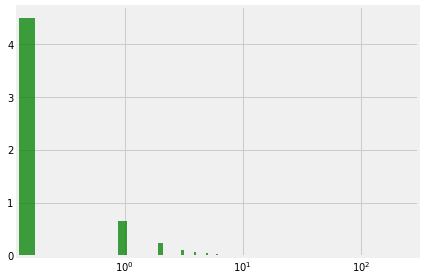

In [11]:
fig1, ax1 = plt.subplots()
ax1.hist(pd.Series(citation_df['citations'].dropna()), 1200, density=True, facecolor='g', alpha=0.75)
ax1.set_xscale("log")
plt.tight_layout()
plt.show()

## Exercise instructions

1. Create a similar query showing the articles that cite the most other papers? Note that you'll only need to do a slight tweak of the Cypher query to do this. 
2. What about a distribution of the number of articles published by authors?

Keep the results of this exercise handy as they may be useful for the quiz at the end of this module.

In [13]:
# Articles that cite the most other articles
query = """
MATCH (a:Article)
RETURN size((a)-[:CITED]->()) AS citations
"""

citation_df = graph.run(query).to_data_frame()
citation_df.describe([.25, .5, .75, .9, .99])

,citations
count,51956.000
mean,0.553
std,1.301
min,0.000
25%,0.000
50%,0.000
75%,1.000
90%,2.000
99%,6.000
max,51.000


In [19]:
# Number of articles published by authors
exploratory_query = """
MATCH (author:Author)<-[:AUTHOR]-(article:Article)
RETURN author.name AS authorName, count(article) as articlesAuthored
ORDER BY articlesAuthored DESC, authorName
LIMIT 10
"""

auth_df = graph.run(exploratory_query).to_data_frame()
auth_df

,authorName,articlesAuthored
0,Peter G. Neumann,89
1,Peter J. Denning,80
2,Moshe Y. Vardi,72
3,Pamela Samuelson,71
4,Bart Preneel,65
5,Vinton G. Cerf,56
6,Barry W. Boehm,53
7,Mark Guzdial,49
8,Edwin R. Hancock,47
9,Josef Kittler,46


In [21]:
# Distribution of # of articles published by authors
auth_df.describe([.25, .5, .75, .9, .99])

,articlesAuthored
count,10.000
mean,62.800
std,14.921
min,46.000
25%,50.000
50%,60.500
75%,71.750
90%,80.900
99%,88.190
max,89.000


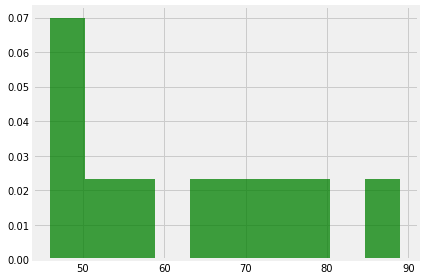

In [35]:
fig1, ax1 = plt.subplots()
ax1.hist(pd.Series(auth_df['articlesAuthored'].dropna()), 10, density=True, facecolor='g', alpha=0.75)
# ax1.set_xscale("log")
plt.tight_layout()
plt.show()